Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.268989
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 50: 2.197814
Minibatch accuracy: 6.2%
Validation accuracy: 32.6%
Minibatch loss at step 100: 1.207311
Minibatch accuracy: 62.5%
Validation accuracy: 66.4%
Minibatch loss at step 150: 0.542183
Minibatch accuracy: 81.2%
Validation accuracy: 74.5%
Minibatch loss at step 200: 0.838389
Minibatch accuracy: 75.0%
Validation accuracy: 77.5%
Minibatch loss at step 250: 1.360626
Minibatch accuracy: 56.2%
Validation accuracy: 77.9%
Minibatch loss at step 300: 0.460812
Minibatch accuracy: 81.2%
Validation accuracy: 79.5%
Minibatch loss at step 350: 0.436336
Minibatch accuracy: 93.8%
Validation accuracy: 77.5%
Minibatch loss at step 400: 0.256568
Minibatch accuracy: 100.0%
Validation accuracy: 79.9%
Minibatch loss at step 450: 0.850095
Minibatch accuracy: 81.2%
Validation accuracy: 78.9%
Minibatch loss at step 500: 0.923786
Minibatch accuracy: 87.5%
Validation accuracy: 81.1%
Mi

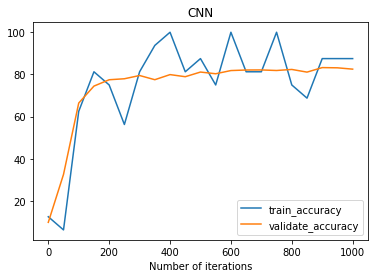

In [9]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('CNN')
plt.show()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [12]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    k =2
    stride = 2
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, k, k, 1], strides=[1, stride, stride, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, k, k, 1], strides=[1, stride, stride, 1],
                          padding='SAME')
      
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
      
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [13]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.100410
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.916154
Minibatch accuracy: 18.8%
Validation accuracy: 47.4%
Minibatch loss at step 100: 1.186981
Minibatch accuracy: 50.0%
Validation accuracy: 58.3%
Minibatch loss at step 150: 0.676329
Minibatch accuracy: 81.2%
Validation accuracy: 69.9%
Minibatch loss at step 200: 0.843886
Minibatch accuracy: 75.0%
Validation accuracy: 76.0%
Minibatch loss at step 250: 1.420982
Minibatch accuracy: 56.2%
Validation accuracy: 78.0%
Minibatch loss at step 300: 0.455831
Minibatch accuracy: 87.5%
Validation accuracy: 79.8%
Minibatch loss at step 350: 0.614466
Minibatch accuracy: 87.5%
Validation accuracy: 78.4%
Minibatch loss at step 400: 0.244805
Minibatch accuracy: 93.8%
Validation accuracy: 79.8%
Minibatch loss at step 450: 0.713502
Minibatch accuracy: 87.5%
Validation accuracy: 77.4%
Minibatch loss at step 500: 0.733920
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
Mi

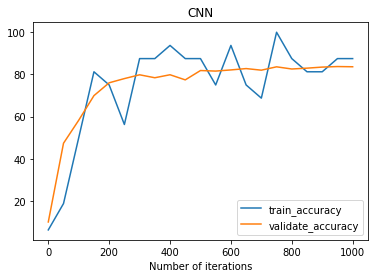

In [14]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('CNN')
plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [23]:
from IPython.display import display, Image
lenet5 = Image(url = 'http://eblearn.sourceforge.net/lib/exe/lenet5.png')

In [24]:
display(lenet5)

Architecture

Layer 1: Convolutional. The output shape is 28x28x6.

Activation. Let's use ReLu activation function.

Pooling. The output shape is 14x14x6.

Layer 2: Convolutional. The output shape is 10x10x16.

Activation. Let's use ReLu activation function.

Pooling. The output shape is 5x5x16.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

Layer 3: Fully Connected. This one have 120 outputs.

Activation. Let's use ReLu activation function.

Layer 4: Fully Connected. This one have 84 outputs.

Activation. Let's use ReLu activation function.

Layer 5: Fully Connected (Logits). This one have 10 outputs.


In [33]:
batch_size = 16
patch_size = 5
depth1 = 6
depth2 = 16
num_hidden_1 = 120
num_hidden_2 = 84

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [5*5*depth2, num_hidden_1], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_1]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_2]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Layer 1: Convolutional. Input = 32x32x1(paper) 28x28x1(here). Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    return tf.matmul(fc2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
#   optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  optimizer =  tf.train.AdamOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [34]:
num_steps = 50001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.037176
Minibatch accuracy: 12.5%
Validation accuracy: 13.3%
Minibatch loss at step 1000: 0.187266
Minibatch accuracy: 93.8%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 0.105570
Minibatch accuracy: 100.0%
Validation accuracy: 85.4%
Minibatch loss at step 3000: 0.756509
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%
Minibatch loss at step 4000: 0.424849
Minibatch accuracy: 81.2%
Validation accuracy: 87.5%
Minibatch loss at step 5000: 1.050762
Minibatch accuracy: 68.8%
Validation accuracy: 87.7%
Minibatch loss at step 6000: 0.098166
Minibatch accuracy: 100.0%
Validation accuracy: 88.3%
Minibatch loss at step 7000: 0.794900
Minibatch accuracy: 68.8%
Validation accuracy: 88.5%
Minibatch loss at step 8000: 0.461133
Minibatch accuracy: 87.5%
Validation accuracy: 88.9%
Minibatch loss at step 9000: 0.228075
Minibatch accuracy: 93.8%
Validation accuracy: 89.3%
Minibatch loss at step 10000: 0.086433
Minibatch accuracy: 100.0%
Validation ac

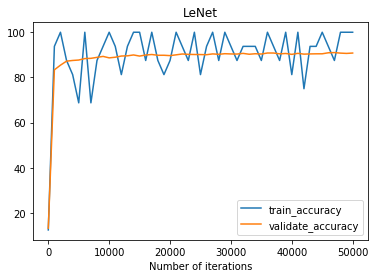

In [36]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('LeNet')
plt.show()

In [43]:
# saver = tf.train.Saver()
# saver.save(sess)

In [48]:
batch_size = 16
patch_size = 5
depth1 = 6
depth2 = 16
num_hidden_1 = 120
num_hidden_2 = 84
drop_out = 0.5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [5*5*depth2, num_hidden_1], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_1]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_2]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Layer 1: Convolutional. Input = 32x32x1(paper) 28x28x1(here). Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    return tf.matmul(fc2, layer5_weights) + layer5_biases

  def model_dropout(data):
    # Layer 1: Convolutional. Input = 32x32x1(paper) 28x28x1(here). Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    fc1 = tf.nn.dropout(fc1, drop_out)
    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)
    fc2 = tf.nn.dropout(fc2, drop_out)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    return tf.matmul(fc2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model_dropout(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
#   optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  optimizer =  tf.train.AdamOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [49]:
num_steps = 50001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.122444
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 1000: 0.698080
Minibatch accuracy: 75.0%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 0.204748
Minibatch accuracy: 93.8%
Validation accuracy: 83.4%
Minibatch loss at step 3000: 0.904498
Minibatch accuracy: 81.2%
Validation accuracy: 85.3%
Minibatch loss at step 4000: 0.470886
Minibatch accuracy: 81.2%
Validation accuracy: 86.1%
Minibatch loss at step 5000: 1.410396
Minibatch accuracy: 62.5%
Validation accuracy: 86.2%
Minibatch loss at step 6000: 0.221585
Minibatch accuracy: 93.8%
Validation accuracy: 86.7%
Minibatch loss at step 7000: 1.095865
Minibatch accuracy: 68.8%
Validation accuracy: 86.6%
Minibatch loss at step 8000: 0.611405
Minibatch accuracy: 81.2%
Validation accuracy: 87.3%
Minibatch loss at step 9000: 0.385470
Minibatch accuracy: 87.5%
Validation accuracy: 87.6%
Minibatch loss at step 10000: 0.080780
Minibatch accuracy: 100.0%
Validation accu

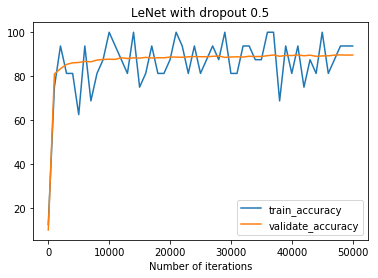

In [50]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('LeNet with dropout 0.5')
plt.show()

In [51]:
batch_size = 16
patch_size = 5
depth1 = 6
depth2 = 16
num_hidden_1 = 120
num_hidden_2 = 84
drop_out = 0.75

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [5*5*depth2, num_hidden_1], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_1]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_2]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Layer 1: Convolutional. Input = 32x32x1(paper) 28x28x1(here). Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    return tf.matmul(fc2, layer5_weights) + layer5_biases

  def model_dropout(data):
    # Layer 1: Convolutional. Input = 32x32x1(paper) 28x28x1(here). Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    fc1 = tf.nn.dropout(fc1, drop_out)
    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)
    fc2 = tf.nn.dropout(fc2, drop_out)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    return tf.matmul(fc2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model_dropout(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
#   optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  optimizer =  tf.train.AdamOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [52]:
num_steps = 50001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.588814
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 1000: 0.738088
Minibatch accuracy: 81.2%
Validation accuracy: 82.6%
Minibatch loss at step 2000: 0.137004
Minibatch accuracy: 100.0%
Validation accuracy: 84.7%
Minibatch loss at step 3000: 0.620944
Minibatch accuracy: 81.2%
Validation accuracy: 85.6%
Minibatch loss at step 4000: 0.349690
Minibatch accuracy: 87.5%
Validation accuracy: 86.1%
Minibatch loss at step 5000: 1.267194
Minibatch accuracy: 68.8%
Validation accuracy: 86.3%
Minibatch loss at step 6000: 0.157814
Minibatch accuracy: 93.8%
Validation accuracy: 87.3%
Minibatch loss at step 7000: 0.629907
Minibatch accuracy: 75.0%
Validation accuracy: 87.8%
Minibatch loss at step 8000: 0.528602
Minibatch accuracy: 81.2%
Validation accuracy: 88.1%
Minibatch loss at step 9000: 0.284151
Minibatch accuracy: 93.8%
Validation accuracy: 87.8%
Minibatch loss at step 10000: 0.172600
Minibatch accuracy: 93.8%
Validation accur

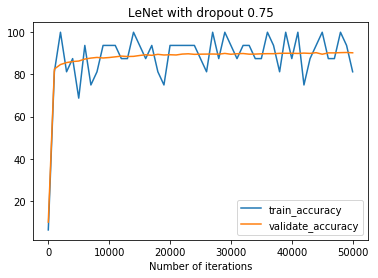

In [53]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('LeNet with dropout 0.75')
plt.show()

With LeNet, the test accuracy reaches 95.9%. However, adding dropout does not realize increase of accuracy